In [109]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
import seaborn as sns
import robust_loss_pytorch.general
from sklearn.preprocessing import scale as scaler
from sklearn.model_selection import KFold
import numpy.random as npr
import robust_loss_pytorch
from robust_loss_pytorch import distribution
import robust_loss_pytorch.general as general
import random
import torch.nn as nn
import pandas as pd
from tqdm import tqdm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

# Construct some regression data with some extreme outliers.
np.random.seed(1234)
torch.manual_seed(1234)



In [2]:
def train_regular(model, trX, trY, dist, learning_rate=0.01, epoch=500, verbose=True):

    params = list(model.parameters())
    optimizer = torch.optim.Adam(params, lr=learning_rate)

    for e in tqdm(range(epoch)):
        y_hat = model(trX).view(-1)
        loss = torch.mean(dist.loss(y_hat, trY))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if verbose and np.mod(e, 100) == 0:
            # You can see the alpha+scale parameters moving around.
            print('{:<4}: loss={:03f}'.format(e, loss.data))
    return model


def train_adaptive(model, trX, trY, learning_rate=0.01, epoch=500, verbose=True):
    adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
        num_dims=1, float_dtype=np.float32, device='cpu', alpha_init=1.998)
    params = list(model.parameters()) + list(adaptive.parameters())
    optimizer = torch.optim.Adam(params, lr=learning_rate)

    for e in tqdm(range(epoch)):
        y_hat = model(trX).view(-1)
        loss = torch.mean(adaptive.lossfun((y_hat - trY)[:,None]))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if verbose and np.mod(e, 100) == 0:
            print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            e, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data))
    return model, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data


def train_locally_adaptive(model, alpha, scale, trX, trY, learning_rate=0.01, epoch=500, verbose=True):
    params = list(model.parameters()) + list(alpha.parameters()) + list(scale.parameters())
    dist = distribution.Distribution()
    optimizer = torch.optim.Adam(params, lr=learning_rate)

    for e in tqdm(range(epoch)):
        y_hat = model(trX).view(-1)
        alphas = torch.exp(alpha(trX))
        scales = torch.exp(scale(trX))
        loss = general.lossfun((y_hat - trY)[:, None], alpha=alphas, scale=scales, approximate=False)
        log_partition = torch.log(scales) + dist.log_base_partition_function(alphas)
        loss = (loss + log_partition).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if verbose and np.mod(e, 100) == 0:
            print('{:<4}: loss={:03f}'.format(e, loss.data))
    return model, alpha, scale


class PolyRegression(nn.Module):
    def __init__(self, dim, init_zeros=False):
        super(PolyRegression, self).__init__()
        self.beta = nn.Linear(dim, 1)
        self.n_poly = dim
        if init_zeros:
            with torch.no_grad():
                self.beta.weight.copy_(torch.zeros(dim))
                self.beta.bias.copy_(torch.zeros(1))

    def forward(self, x):
        """
        x: N x dim
        """
        expand = [(x**(i+1)).view(-1, 1) for i in range(self.n_poly)]
        expand = torch.cat(expand, dim=1)
        return self.beta(expand)


class AdaptiveRegression(nn.Module):
    def __init__(self):
        pass

    def forward(self, x):
        pass

In [3]:
class Gaussian(object):
    def loss(self, x, y):
        return (x-y)**2

    def loglikelihood(self, res, sigma=None):
        """
        calculate log likelihood of residuals
        :param res:
        :return:
        """
        # sample variance
        if sigma is None:
            sigma = np.mean(res**2)
        N = len(res)
        ll = -N/2*np.log(2*np.pi*sigma) - 1/(2*sigma)*np.sum(res**2)
        return ll


class Laplace(object):
    def loss(self, x, y):
        return torch.abs(x-y)

    def loglikelihood(self, res, b=None):
        """
        calculate log likelihood of residuals
        :param res:
        :return:
        """
        # sample variance
        if b is None:
            b = np.sqrt(np.mean(res ** 2)/2)
        N = len(res)
        ll = -N*np.log(2*b) - 1/b*np.sum(np.abs(res))
        return ll


class Adaptive(object):
    def loglikelihood(self, res, alpha, scale):
        assert alpha.view(-1).size()[0] == 1 or alpha.view(-1).size()[0] == len(res)
        N = len(res)
        dist = distribution.Distribution()
        loss = general.lossfun(res, alpha, scale, approximate=False).sum()
        log_partition = torch.log(scale) + dist.log_base_partition_function(alpha)
        if alpha.view(-1).size()[0] == 1:
            log_partition = N*log_partition
        else:
            log_partition = log_partition.sum()
        nll = loss + log_partition
        return -nll.detach().numpy()

    def sample(self, alpha, c):
        alpha = torch.as_tensor(alpha)
        scale = torch.as_tensor(c)
        assert (alpha >= 0).all()
        assert (scale >= 0).all()
        float_dtype = alpha.dtype
        assert scale.dtype == float_dtype

        cauchy = torch.distributions.cauchy.Cauchy(0., np.sqrt(2.))
        uniform = torch.distributions.uniform.Uniform(0, 1)
        samples = torch.zeros_like(alpha)
        accepted = torch.zeros(alpha.shape).type(torch.bool)
        dist = distribution.Distribution()
        while not accepted.type(torch.uint8).all():
            # Draw N samples from a Cauchy, our proposal distribution.
            cauchy_sample = torch.reshape(
              cauchy.sample((np.prod(alpha.shape),)), alpha.shape)
            cauchy_sample = cauchy_sample.type(alpha.dtype)

            # Compute the likelihood of each sample under its target distribution.
            nll = dist.nllfun(cauchy_sample,
                            torch.as_tensor(alpha).to(cauchy_sample),
                            torch.tensor(1).to(cauchy_sample))

            # Bound the NLL. We don't use the approximate loss as it may cause
            # unpredictable behavior in the context of sampling.
            nll_bound = general.lossfun(
              cauchy_sample,
              torch.tensor(0., dtype=cauchy_sample.dtype),
              torch.tensor(1., dtype=cauchy_sample.dtype),
              approximate=False) + dist.log_base_partition_function(alpha)

            # Draw N samples from a uniform distribution, and use each uniform sample
            # to decide whether or not to accept each proposal sample.
            uniform_sample = torch.reshape(
              uniform.sample((np.prod(alpha.shape),)), alpha.shape)
            uniform_sample = uniform_sample.type(alpha.dtype)
            accept = uniform_sample <= torch.exp(nll_bound - nll)

            # If a sample is accepted, replace its element in `samples` with the
            # proposal sample, and set its bit in `accepted` to True.
            samples = torch.where(accept, cauchy_sample, samples)
            accepted = accepted | accept

            # Because our distribution is a location-scale family, we sample from
            # p(x | 0, \alpha, 1) and then scale each sample by `scale`.
            samples *= scale
        return samples

# Heteroskedastic data: LIDAR

c:\users\cecilia\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


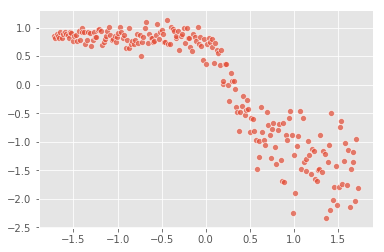

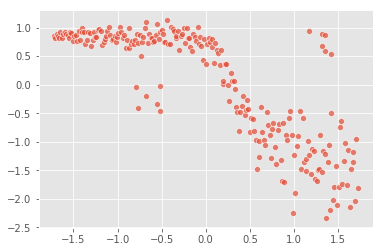

In [99]:
X = pd.read_csv('../dataset/lidar.tsv', sep='  ')
x_range = X['range']
y_ratio = X['logratio']

x_range = np.array((x_range-np.mean(x_range))/np.std(x_range))
y_ratio = np.array((y_ratio-np.mean(y_ratio))/np.std(y_ratio))
sns.scatterplot(x_range, y_ratio, alpha=0.7)
plt.show()

x_out1 = np.random.uniform(low=-0.8, high=-0.5, size=(6,))
y_out1 = np.random.uniform(low=-0.5, high=0, size=(6,))
x_out2 = np.random.uniform(low=1, high=1.5, size=(6,))
y_out2 = np.random.uniform(low=0.5, high=1, size=(6,))

x_range_out = np.concatenate((x_range,x_out1), axis=0)
x_range_out = np.concatenate((x_range_out,x_out2), axis=0)
y_ratio_out = np.concatenate((y_ratio,y_out1), axis=0)
y_ratio_out = np.concatenate((y_ratio_out,y_out2), axis=0)
sns.scatterplot(x_range_out, y_ratio_out, alpha=0.7)

# Heteroskedastic data: MOTOR

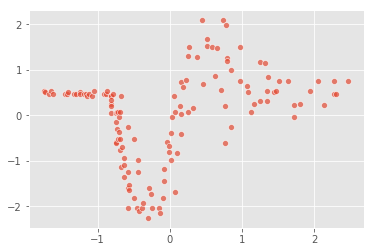

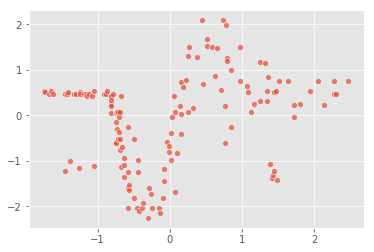

In [122]:
X = pd.read_csv('../dataset/mcycle.csv')
x_motor = X['times']
y_motor = X['accel']
x_motor = scaler(x_motor)
y_motor = scaler(y_motor)

x_out1 = np.random.uniform(low=-1.5, high=-1, size=(4,))
y_out1 = np.random.uniform(low=-1, high=-1.4, size=(4,))
x_out2 = np.random.uniform(low=1.3, high=1.5, size=(5,))
y_out2 = np.random.uniform(low=-1, high=-1.5, size=(5,))

x_motor_out = np.concatenate((x_motor,x_out1), axis=0)
x_motor_out = np.concatenate((x_motor_out,x_out2), axis=0)
y_motor_out = np.concatenate((y_motor,y_out1), axis=0)
y_motor_out = np.concatenate((y_motor_out,y_out2), axis=0)

sns.scatterplot(x_motor, y_motor, alpha=0.7)
plt.show()

sns.scatterplot(x_motor_out, y_motor_out, alpha=0.7)
plt.show()

In [138]:
dataset = 'lidar'   #'motor'
outliers = True

if outliers:
    x_range, y_ratio = x_range_out, y_ratio_out

if dataset=='lidar':
    if outliers:
        x_range, y_ratio = x_range_out, y_ratio_out
    trX, teX, trY, teY = train_test_split(x_range, y_ratio, test_size=0.3, random_state=0)
elif dataset=='motor':
    if outliers:
        x_motor, y_motor = x_motor_out, y_motor_out
    trX, teX, trY, teY = train_test_split(x_motor, y_motor, test_size=0.3, random_state=0)

In [139]:
print(trX.shape, trY.shape)

(163,) (163,)


In [140]:
gaussian = Gaussian()
laplace = Laplace()
adaptive = Adaptive()

## Polynomial regression with regular, adaptive and locally adaptive

In [141]:
x, y = torch.Tensor(trX), torch.Tensor(trY)

# define regression degree
reg_degree = 5

# define regression model
lr = PolyRegression(reg_degree)

# regular loss training
reg_fit = train_regular(lr, x, y, gaussian, epoch=1000, learning_rate=1e-2, verbose=False)

# ada loss training
ada_fit, alpha, scale = train_adaptive(lr, x, y, learning_rate=0.01, epoch=500, verbose=False)

# adalocal loss training
alpha_model = PolyRegression(5, init_zeros=True)
scale_model = PolyRegression(5, init_zeros=True)
ada_loc_fit, alpha_loc, scale_loc = train_locally_adaptive(lr, alpha_model, scale_model, x,y, learning_rate=0.01, epoch=500, verbose=False)

100%|███████████████████████████████████████| 500/500 [00:02<00:00, 192.60it/s]


In [148]:
x, y = torch.Tensor(trX), torch.Tensor(trY)

n_splits = 5

cv = KFold(n_splits=n_splits, shuffle=True, random_state=3)

reg_degrees = 10

table = np.zeros((reg_degrees, 3))

for i in range(reg_degrees):
    
    reg_degree = i+1
    print(reg_degree)
    
    gauss_log_likelihoods = np.zeros((n_splits,1))
    ada_log_likelihoods = np.zeros((n_splits,1))
    adaloc_log_likelihoods = np.zeros((n_splits,1))
    
    j = 0

    for train_index, test_index in cv.split(x):
            
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # define regression model
        lr = PolyRegression(reg_degree)

        # regular loss training
        reg_fit = train_regular(lr, X_train, y_train, gaussian, epoch=500, learning_rate=0.01, verbose=False)

        # ada loss training
        ada_fit, alpha, scale = train_adaptive(lr, X_train, y_train, learning_rate=0.01, epoch=500, verbose=False)

        # adalocal loss training
        alpha_model = PolyRegression(2, init_zeros=True)
        scale_model = PolyRegression(2, init_zeros=True)
        ada_loc_fit, alpha_loc, scale_loc = train_locally_adaptive(lr, alpha_model, scale_model, X_train, y_train, 
                                                                   learning_rate=0.01, epoch=500, verbose=False)

        sortedx, idxX = torch.sort(X_test)
        y2 = reg_fit(sortedx).detach().view(-1)
        yar = ada_fit(sortedx).detach().view(-1)
        yalr = ada_loc_fit(sortedx).detach().view(-1)
        alphas = torch.exp(alpha_model(sortedx).view(-1))
        scales = torch.exp(scale_model(sortedx).view(-1))
        
        gauss_log_lik = gaussian.loglikelihood(y2.numpy().flatten()-y_test.numpy().flatten())
        ada_log_lik = adaptive.loglikelihood(yar-y_test[idxX], alpha, scale)
        adaloc_log_lik = adaptive.loglikelihood(yalr-y_test[idxX], alphas, scales)
        
        gauss_log_likelihoods[j,:] = gauss_log_lik
        ada_log_likelihoods[j,:] = ada_log_lik
        adaloc_log_likelihoods[j,:] = adaloc_log_lik

        print('Polynomial degree ', reg_degree)
        print('Gaussian Log Likelihood: ', gaussian.loglikelihood(y2.numpy().flatten()-y_test.numpy().flatten()))
        print('Adaptive Log Likelihood: ', adaptive.loglikelihood(yar-y_test[idxX], alpha, scale))
        print('Ada+reg Log Likelihood : ', adaptive.loglikelihood(yalr-y_test[idxX], alphas, scales))

        j += 1
    
    gauss_log_likelihood_mean = np.mean(gauss_log_likelihoods)
    ada_log_likelihood_mean = np.mean(ada_log_likelihoods)
    adaloc_log_likelihood_mean = np.mean(adaloc_log_likelihoods)
    
    table[i, 0] = gauss_log_likelihood_mean
    table[i, 1] = ada_log_likelihood_mean
    table[i, 2] = adaloc_log_likelihood_mean
    
    
    

1


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 246.67it/s]


Polynomial degree  1
Gaussian Log Likelihood:  -50.68096396810205
Adaptive Log Likelihood:  -38.389595
Ada+reg Log Likelihood :  -30.702019


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 248.76it/s]


Polynomial degree  1
Gaussian Log Likelihood:  -54.02860469414246
Adaptive Log Likelihood:  -26.830929
Ada+reg Log Likelihood :  -18.187561


100%|███████████████████████████████████████| 500/500 [00:01<00:00, 253.16it/s]


Polynomial degree  1
Gaussian Log Likelihood:  -49.14793609403995
Adaptive Log Likelihood:  -30.639923
Ada+reg Log Likelihood :  -25.257301


100%|███████████████████████████████████████| 500/500 [00:01<00:00, 256.28it/s]


Polynomial degree  1
Gaussian Log Likelihood:  -51.24205725462296
Adaptive Log Likelihood:  -35.30923
Ada+reg Log Likelihood :  -23.832254


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 233.10it/s]


Polynomial degree  1
Gaussian Log Likelihood:  -44.41502517310723
Adaptive Log Likelihood:  -27.186787
Ada+reg Log Likelihood :  -19.123907
2


100%|███████████████████████████████████████| 500/500 [00:01<00:00, 250.75it/s]


Polynomial degree  2
Gaussian Log Likelihood:  -57.52196636747175
Adaptive Log Likelihood:  -33.553074
Ada+reg Log Likelihood :  -31.88892


100%|███████████████████████████████████████| 500/500 [00:01<00:00, 250.63it/s]


Polynomial degree  2
Gaussian Log Likelihood:  -57.701071995317875
Adaptive Log Likelihood:  -21.425741
Ada+reg Log Likelihood :  -9.847496


100%|███████████████████████████████████████| 500/500 [00:01<00:00, 254.71it/s]


Polynomial degree  2
Gaussian Log Likelihood:  -55.45520982325486
Adaptive Log Likelihood:  -28.883982
Ada+reg Log Likelihood :  -12.522226


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 248.51it/s]


Polynomial degree  2
Gaussian Log Likelihood:  -54.35737867205889
Adaptive Log Likelihood:  -32.526184
Ada+reg Log Likelihood :  -23.212048


100%|███████████████████████████████████████| 500/500 [00:01<00:00, 260.32it/s]


Polynomial degree  2
Gaussian Log Likelihood:  -47.230444494392586
Adaptive Log Likelihood:  -20.935032
Ada+reg Log Likelihood :  -3.2708817
3


100%|███████████████████████████████████████| 500/500 [00:01<00:00, 253.04it/s]


Polynomial degree  3
Gaussian Log Likelihood:  -57.31482510566379
Adaptive Log Likelihood:  -33.61051
Ada+reg Log Likelihood :  -33.074802


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 243.31it/s]


Polynomial degree  3
Gaussian Log Likelihood:  -57.74109507566291
Adaptive Log Likelihood:  -22.010263
Ada+reg Log Likelihood :  -10.049223


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 186.57it/s]


Polynomial degree  3
Gaussian Log Likelihood:  -55.13466091501577
Adaptive Log Likelihood:  -28.727367
Ada+reg Log Likelihood :  -13.598028


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 185.74it/s]


Polynomial degree  3
Gaussian Log Likelihood:  -54.36904159247811
Adaptive Log Likelihood:  -34.05067
Ada+reg Log Likelihood :  -23.251125


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 169.15it/s]


Polynomial degree  3
Gaussian Log Likelihood:  -47.03645897702002
Adaptive Log Likelihood:  -20.491444
Ada+reg Log Likelihood :  -5.1686454
4


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 190.84it/s]


Polynomial degree  4
Gaussian Log Likelihood:  -57.86480489180224
Adaptive Log Likelihood:  -28.951504
Ada+reg Log Likelihood :  -23.258488


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 187.90it/s]


Polynomial degree  4
Gaussian Log Likelihood:  -60.31925490905893
Adaptive Log Likelihood:  -15.586956
Ada+reg Log Likelihood :  -8.251869


100%|███████████████████████████████████████| 500/500 [00:03<00:00, 162.39it/s]


Polynomial degree  4
Gaussian Log Likelihood:  -52.70929352203186
Adaptive Log Likelihood:  -27.170752
Ada+reg Log Likelihood :  -8.491335


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 195.77it/s]


Polynomial degree  4
Gaussian Log Likelihood:  -54.69083343017537
Adaptive Log Likelihood:  -33.205795
Ada+reg Log Likelihood :  -20.509703


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 241.55it/s]


Polynomial degree  4
Gaussian Log Likelihood:  -48.3081798194603
Adaptive Log Likelihood:  -18.875957
Ada+reg Log Likelihood :  4.1693068
5


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 225.12it/s]


Polynomial degree  5
Gaussian Log Likelihood:  -57.58644278131765
Adaptive Log Likelihood:  -28.916016
Ada+reg Log Likelihood :  -21.658522


100%|███████████████████████████████████████| 500/500 [00:01<00:00, 256.28it/s]


Polynomial degree  5
Gaussian Log Likelihood:  -60.1080440296031
Adaptive Log Likelihood:  -15.236709
Ada+reg Log Likelihood :  -8.580156


100%|███████████████████████████████████████| 500/500 [00:01<00:00, 255.10it/s]


Polynomial degree  5
Gaussian Log Likelihood:  -52.41165585626923
Adaptive Log Likelihood:  -27.866882
Ada+reg Log Likelihood :  -8.243608


100%|███████████████████████████████████████| 500/500 [00:01<00:00, 254.32it/s]


Polynomial degree  5
Gaussian Log Likelihood:  -54.573002937734095
Adaptive Log Likelihood:  -33.629375
Ada+reg Log Likelihood :  -21.8544


100%|███████████████████████████████████████| 500/500 [00:01<00:00, 250.75it/s]


Polynomial degree  5
Gaussian Log Likelihood:  -48.27148551837295
Adaptive Log Likelihood:  -18.790848
Ada+reg Log Likelihood :  4.0202456
6


100%|███████████████████████████████████████| 500/500 [00:01<00:00, 254.45it/s]


Polynomial degree  6
Gaussian Log Likelihood:  -57.57344633386562
Adaptive Log Likelihood:  -27.273968
Ada+reg Log Likelihood :  -24.23368


100%|███████████████████████████████████████| 500/500 [00:01<00:00, 253.16it/s]


Polynomial degree  6
Gaussian Log Likelihood:  -60.452524880141155
Adaptive Log Likelihood:  -12.319577
Ada+reg Log Likelihood :  -4.2268105


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 249.88it/s]


Polynomial degree  6
Gaussian Log Likelihood:  -53.7805162288591
Adaptive Log Likelihood:  -23.218025
Ada+reg Log Likelihood :  -5.842598


100%|███████████████████████████████████████| 500/500 [00:01<00:00, 254.71it/s]


Polynomial degree  6
Gaussian Log Likelihood:  -54.96229418527001
Adaptive Log Likelihood:  -36.221855
Ada+reg Log Likelihood :  -20.003857


100%|███████████████████████████████████████| 500/500 [00:01<00:00, 255.62it/s]


Polynomial degree  6
Gaussian Log Likelihood:  -48.13418982817886
Adaptive Log Likelihood:  -17.423832
Ada+reg Log Likelihood :  2.4161243
7


100%|███████████████████████████████████████| 500/500 [00:01<00:00, 253.04it/s]


Polynomial degree  7
Gaussian Log Likelihood:  -57.51364283704142
Adaptive Log Likelihood:  -27.751623
Ada+reg Log Likelihood :  -18.915293


100%|███████████████████████████████████████| 500/500 [00:03<00:00, 166.00it/s]


Polynomial degree  7
Gaussian Log Likelihood:  -59.532413933741736
Adaptive Log Likelihood:  -11.987799
Ada+reg Log Likelihood :  -4.5704722


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 170.07it/s]


Polynomial degree  7
Gaussian Log Likelihood:  -54.33746492317472
Adaptive Log Likelihood:  -22.040462
Ada+reg Log Likelihood :  -7.3749857


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 175.56it/s]


Polynomial degree  7
Gaussian Log Likelihood:  -54.83577437576149
Adaptive Log Likelihood:  -36.545128
Ada+reg Log Likelihood :  -19.646296


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 184.16it/s]


Polynomial degree  7
Gaussian Log Likelihood:  -47.96310933655986
Adaptive Log Likelihood:  -17.268013
Ada+reg Log Likelihood :  5.9745483
8


100%|███████████████████████████████████████| 500/500 [00:03<00:00, 149.30it/s]


Polynomial degree  8
Gaussian Log Likelihood:  -57.56381962209704
Adaptive Log Likelihood:  -27.723953
Ada+reg Log Likelihood :  -25.19191


100%|███████████████████████████████████████| 500/500 [00:03<00:00, 147.75it/s]


Polynomial degree  8
Gaussian Log Likelihood:  -59.55773473256068
Adaptive Log Likelihood:  -12.835533
Ada+reg Log Likelihood :  -6.3289876


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 185.25it/s]


Polynomial degree  8
Gaussian Log Likelihood:  -53.25958991436791
Adaptive Log Likelihood:  -24.200808
Ada+reg Log Likelihood :  -7.8956375


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 225.63it/s]


Polynomial degree  8
Gaussian Log Likelihood:  -54.62324839683798
Adaptive Log Likelihood:  -36.14036
Ada+reg Log Likelihood :  -22.591576


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 241.20it/s]


Polynomial degree  8
Gaussian Log Likelihood:  -48.00027036996013
Adaptive Log Likelihood:  -17.90395
Ada+reg Log Likelihood :  -1.5621681
9


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 248.51it/s]


Polynomial degree  9
Gaussian Log Likelihood:  -57.42016903139783
Adaptive Log Likelihood:  -27.910112
Ada+reg Log Likelihood :  -27.148237


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 246.18it/s]


Polynomial degree  9
Gaussian Log Likelihood:  -59.545200067569
Adaptive Log Likelihood:  -13.780275
Ada+reg Log Likelihood :  -21.870165


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 228.94it/s]


Polynomial degree  9
Gaussian Log Likelihood:  -53.29222392237243
Adaptive Log Likelihood:  -23.400745
Ada+reg Log Likelihood :  -10.850589


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 247.65it/s]


Polynomial degree  9
Gaussian Log Likelihood:  -54.184641390334235
Adaptive Log Likelihood:  -35.924953
Ada+reg Log Likelihood :  -23.691874


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 248.14it/s]


Polynomial degree  9
Gaussian Log Likelihood:  -47.91467353561987
Adaptive Log Likelihood:  -17.655697
Ada+reg Log Likelihood :  -6.052108
10


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 249.13it/s]


Polynomial degree  10
Gaussian Log Likelihood:  -123.54427668556397
Adaptive Log Likelihood:  -7139.2593
Ada+reg Log Likelihood :  -208.37505


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 242.72it/s]


Polynomial degree  10
Gaussian Log Likelihood:  -116.2564194128422
Adaptive Log Likelihood:  -3269.3958
Ada+reg Log Likelihood :  -132.68234


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 206.44it/s]


Polynomial degree  10
Gaussian Log Likelihood:  -102.94312715988792
Adaptive Log Likelihood:  -2105.0164
Ada+reg Log Likelihood :  -84.23982


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 233.75it/s]


Polynomial degree  10
Gaussian Log Likelihood:  -54.14772650220785
Adaptive Log Likelihood:  -34.68911
Ada+reg Log Likelihood :  -27.144627


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 226.86it/s]


Polynomial degree  10
Gaussian Log Likelihood:  -47.34098529591874
Adaptive Log Likelihood:  -17.565218
Ada+reg Log Likelihood :  -17.22258


In [149]:
table   #col 0: gaussian, col 1: ada, col 2: adaloc

array([[  -49.90291744,   -31.67129288,   -23.42060852],
       [  -54.45321427,   -27.46480255,   -16.14831429],
       [  -54.31921633,   -27.77805138,   -17.02836485],
       [  -54.77847331,   -24.75819283,   -11.26841755],
       [  -54.59012622,   -24.88796597,   -11.26328831],
       [  -54.98059429,   -23.29145145,   -10.37816429],
       [  -54.83648108,   -23.11860504,    -8.90649958],
       [  -54.60093261,   -23.7609211 ,   -12.71405573],
       [  -54.47138159,   -23.73435669,   -17.92259445],
       [  -88.84650701, -2513.1851429 ,   -93.93288345]])

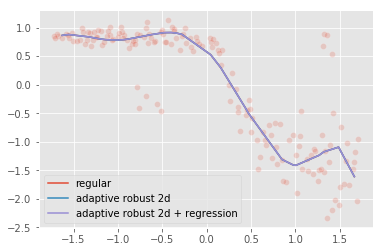

In [146]:
sns.scatterplot(trX, trY, alpha=0.2)
sns.lineplot(sortedx.detach().numpy(), y2.detach().numpy().flatten(), label='regular')
sns.lineplot(sortedx.detach().numpy(), yar.detach().numpy().flatten(), label='adaptive robust 2d')
sns.lineplot(sortedx.detach().numpy(), yalr.detach().numpy().flatten(), label='adaptive robust 2d + regression')